# Experiments on learning agents playing games

In this notebook I made experiments on populations of learning agents. Each experiment includes multiple iterations, in which random groups of agents are selected to play against each other. Usually, the group size is 2, but it depends on the game. The agents don't know who their playing against, nor their chosen strategies. Every agent selects his strategy given an historical information. I exemined two such types of information:  
  
(1) The strategies his opponents in the previous games have chosen.  
  
(2) The strategies his opponents in the current games have chosen in previous games.

The agent must use this information in order to predict the optimal strategy for the current game. After all players chose their strategies, their payoff for the current game is determined using the game payoff matrix. For example, in the following Hawk-Dove game

|          | Straight | Swerve |
|----------|----------|--------|
| Straight | (-1, -1) | (8, 0) |
| Swerve   | (0, 8)   | (4, 4) |

If player 1 choose "straight" and player 2 choose "swerve", the payoff of player 1 is 8 and the payoff of player 2 is 0 (An agent is arbitrarily selected to be player 1 or player 2).

Each agent is "punished" according to its payoff, using a loss function. I tested two such functions:  
  
(1) Direct payoff estimation. Given the strategies chosen by his opponents, the potential payoff is calculated for each possible strategy the agent could choose. The loss is then the mean squared error (MSE) of the differences between the actual payoffs and the ones predicted by the agent. In our example, if the columns player chose "Straight", the potential payoffs for the rows player are -1 and 0. If the rows player estimations are 0 and 4, the final loss is 
$$\frac{(-1 - 0)^2 + (0 - 4)^2}{2} = 8.5$$ 
  
(2) Probabilistic. The potential payoffs for each possible strategy are calculated similarily. Only this time, both the actuall payoffs and the estimated ones are transformed into probability vectors using the softmax function. The error is then determined using the cross entropy between the resulting probability distributions.  
  
The agents were implemented using Recurrent Neural Networks (RNN). These neural networks can take sequences of varying lentghts as inputs. Each iteration in the experiment is also a training iteration for each of the networks. The loss minimization is done using a gradient descent based algorithm (adam).  

This notebook contain 4 games with varying number of players/strategies. More games can be easily added simply by defining their payoff matrix.  
Game data is collected during the game execution so it could be analysed thereafter.

In [ ]:
!pip install tensorflow==2.1.0 Keras==2.3.1 --quiet

In [1]:
import numpy as np
from scipy.special import softmax
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Reshape
from keras import backend as K
import tensorflow as tf
from tqdm.auto import tqdm

Using TensorFlow backend.


Games payoff matrices

In [2]:
GAME_DEFINITIONS = {

    'Rock paper scissors': {
        'strategies': ['Rock', 'Paper', 'Scissors'],
        'rewards': 
            [[[0, 0], [-1, 1], [1, -1]],
             [[1, -1], [0, 0], [-1, 1]],
             [[-1, 1], [1, -1], [0, 0]]]
    },
    
    'Hawk Dove': {
        'strategies': ['Straight', 'Swerve'],
        'rewards': 
            [[[-1, -1], [8, 0]],
             [[0, 8], [4, 4]]]
    },
    
    'Pollution game': {
        'strategies': ['Pollute', 'Purify'],
        'rewards': 
            [
             [ #1 pollute
              [ #2 pollute
               [4, 3, 3], #3 pollute
               [3, 3, 4] #3 purify
                ], 
              [ #2 purify
               [3, 4, 3], #3 pollute
               [0, 1, 1], #3 purify
              ]
              ],
             [ #1 purify
              [ #2 pollute
               [4, 3, 3], #3 pollute
               [1, 0, 1] #3 purify
                ], 
              [ #2 purify
               [1, 1, 0], #3 pollute
               [1, 1, 1], #3 purify
              ]
             ]
            ]
    }
}

## Experiment \#1
**Game:** Hawk Dove (2 players)  
**Input:** previous opponents strategies  
**Loss:** payoff prediction

In [39]:
POPULATION_SIZE = 100
MEMORY = 7
MEMORY_TYPE = 'previous_opponents_strategies'
LOSS_FUNCTION = 'payoff_estimation'
ITERATIONS = 300
GAME = 'Hawk Dove'

In [40]:
game_strategies = np.array(GAME_DEFINITIONS[GAME]['strategies'])
game_rewards = np.array(GAME_DEFINITIONS[GAME]['rewards'])
game_num_of_players = game_rewards.ndim - 1
game_num_of_strategies = len(game_strategies)

if POPULATION_SIZE % game_num_of_players > 0:
    raise Exception('POPULATION_SIZE must be a multiple of the number of players')

In [41]:
def get_loss_function():

    if LOSS_FUNCTION == 'probabilistic':
        return lambda y_true, y_pred: tf.keras.losses.categorical_crossentropy(tf.nn.softmax(y_true), 
                                                                               y_pred, 
                                                                               from_logits=True)

    elif LOSS_FUNCTION == 'payoff_estimation':
        return lambda y_true, y_pred: tf.keras.losses.MSE(y_true, y_pred)

    else:
        raise Exception('Unknown LOSS_FUNCTION')

loss = get_loss_function()

def get_histories():
    
    if MEMORY_TYPE == 'previous_opponents_strategies':
        first_history_record = [np.zeros(len(game_strategies))] * (game_num_of_players - 1)
        return [[first_history_record]  for i in range(POPULATION_SIZE)], first_history_record

    elif MEMORY_TYPE == 'opponents_previous_strategies':
        first_history_record = [np.zeros(len(game_strategies))] * (game_num_of_players - 1)
        return [[first_history_record[0]]  for i in range(POPULATION_SIZE)], first_history_record

    elif MEMORY_TYPE == 'previous_opponents':
        first_history_record = [np.zeros(POPULATION_SIZE)] * (game_num_of_players - 1) 
        return [[first_history_record]  for i in range(POPULATION_SIZE)], first_history_record

    else:
        raise Exception('Unknown MEMORY_TYPE')
        
histories, first_history_record = get_histories()

Agents neural networks initialization

In [42]:
def init_agents():
    
    K.clear_session()

    agents = []

    for i in range(POPULATION_SIZE):

        inp = Input(shape=(None, *np.shape(first_history_record)))
        lstm = LSTM(30)(Reshape((-1, (game_num_of_players - 1) * game_num_of_strategies))(inp))
        dense = Dense(len(game_strategies), activation='linear')(lstm)

        model = Model(inputs=inp, outputs=dense)
        model.compile(optimizer='adam', loss=loss)
        agents.append(model)

    return np.array(agents)

agents = init_agents()

Game execution

In [43]:
def execute_experiment():

    game_results = []
    one_hot_encoder = np.eye(game_num_of_strategies)

    for i in tqdm(range(ITERATIONS)):

        perm = np.random.permutation(POPULATION_SIZE)
        groups = [perm[j:j + game_num_of_players] for j in range(0, POPULATION_SIZE, 
                                                                 game_num_of_players)]
        iteration_strategies = np.array([], dtype=np.int)

        for group in groups:

            group_inputs = []
            group_predictions = np.array([])
            group_strategies = np.array([], dtype=np.int)

            for agent_index in group:

                agent = agents[agent_index]

                if MEMORY_TYPE in ('previous_opponents_strategies', 'previous_opponents'):
                    agent_input = np.array(histories[agent_index])[None]

                elif MEMORY_TYPE == 'opponents_previous_strategies':
                    other_agents_histories = []

                    for other_agent_index in group:
                        if other_agent_index != agent_index:
                            other_agents_histories.append(histories[other_agent_index])

                    agent_input = np.transpose(other_agents_histories, (1, 0, 2))[None]

                else:
                    raise Exception('Unknown MEMORY_TYPE')

                group_inputs.append(agent_input)
                # Get agent's strategy based on previous oponents strategies
                prediction = agent.predict(agent_input)
                group_predictions = np.append(group_predictions, prediction.squeeze())

                strategy = np.argmax(prediction)
                group_strategies = np.append(group_strategies, strategy)

            for player_index, agent_index in enumerate(group):

                agent = agents[agent_index]
                rewards = np.array([])

                # Get reward for each possible strategy the player could take
                for possible_strategy in range(game_rewards.shape[player_index]):
                    scenario = group_strategies.copy()
                    scenario[player_index] = possible_strategy
                    scenario = np.append(scenario, player_index)
                    rewards = np.append(rewards, game_rewards[tuple(scenario)])

                loss = agent.train_on_batch(group_inputs[player_index], rewards[None])

                # Update agents histories
                agent_history = histories[agent_index]

                if MEMORY_TYPE in ('previous_opponents_strategies', 'previous_opponents'):
                    history_record = np.delete(group_strategies, player_index)
                    agent_history.append(one_hot_encoder[history_record])

                elif MEMORY_TYPE == 'opponents_previous_strategies':
                    agent_history.append(one_hot_encoder[group_strategies[player_index]])

                # Keep only the last MEMORY records in the agent's history
                histories[agent_index] = histories[agent_index][-MEMORY:]

                game_results.append({'iteration': i, 'agent': agent_index, 
                                     'rewards': rewards, 'loss': loss,
                                     'strategy_index': group_strategies[player_index],
                                     'prediction': group_predictions[player_index]})

            iteration_strategies = np.concatenate([iteration_strategies, group_strategies])
            
    game_results = pd.DataFrame(game_results).sort_values(['iteration', 'agent'])
    game_results['strategy'] = game_strategies[game_results['strategy_index'].values]
    game_results['actual_reward'] = game_results.apply(lambda x: x['rewards'][x['strategy_index']], axis=1)
    
    return game_results

df = execute_experiment()

### Experiment results analysis

In [44]:
df.head()

,iteration,agent,rewards,loss,strategy_index,prediction,strategy,actual_reward
6,0,0,"[-1.0, 0.0]",0.5,0,0.0,Straight,-1.0
39,0,1,"[-1.0, 0.0]",0.5,0,0.0,Straight,-1.0
51,0,2,"[-1.0, 0.0]",0.5,0,0.0,Straight,-1.0
56,0,3,"[-1.0, 0.0]",0.5,0,0.0,Straight,-1.0
76,0,4,"[-1.0, 0.0]",0.5,0,0.0,Straight,-1.0


Loss values over game iterations of an arbirary agent.  
The color of the line indicates the strategy selected by this agent at that generation: straight - red, swerve - blue.

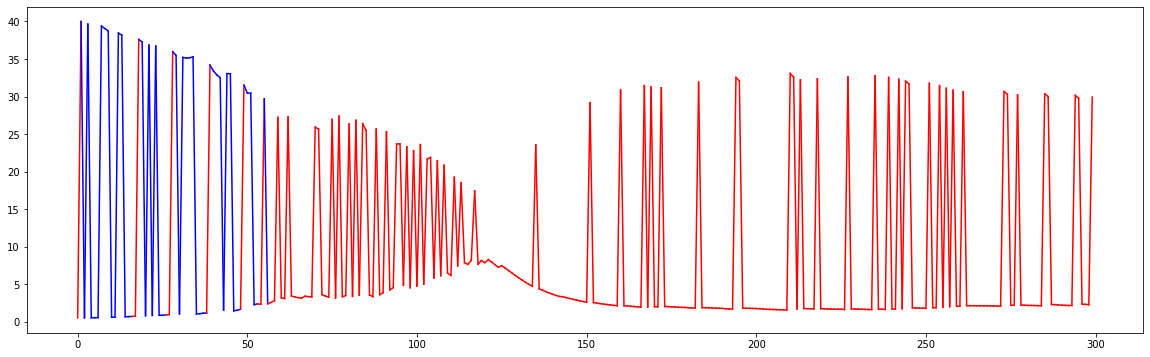

In [45]:
fig, ax = plt.subplots(figsize=(20, 6))

random_agent = df.sample(1).iloc[0]['agent']
agent_data = df[df['agent'] == random_agent].set_index('iteration')

for i in range(1, ITERATIONS):
    color = ('blue', 'red')[int(agent_data.loc[i, 'strategy_index'] == 0)]
    ax.plot([i - 1, i], agent_data.loc[[i - 1, i], 'loss'], color=color)

Let $s_i$ we the number of times the agent $i$ called "swerve" and $T$ the total number of iterations.  
We calaculate $p_i=\frac{s_i}{T}$ for each agent.  
This is the histogram of $p_i$ for all the agents.  
The higher the value on the X axis, the higher is the number of time the agent chose "swerve".

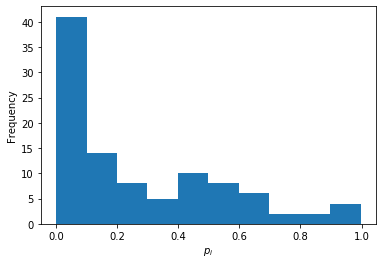

In [51]:
p_i = df.groupby('agent')['strategy_index'].mean()
p_i.plot.hist()
plt.xlabel(r'$p_i$');

In [52]:
R_i = df.groupby('agent')['actual_reward'].sum()
R_i.corr(p_i)

-0.7344475491006931

Here we can see a quite strong negative correlation between $p_i$ and the sum of rewards $R_i$ for a player $i$ (approximatly -0.8)

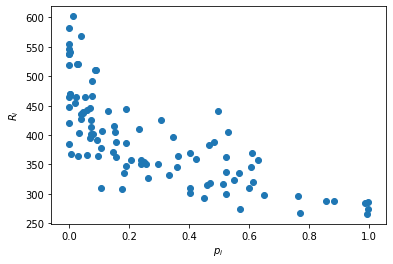

In [53]:
R_i = df.groupby('agent')['actual_reward'].sum()
plt.scatter(p_i, R_i)
plt.xlabel(r'$p_i$')
plt.ylabel(r'$R_i$');

The proportion of "swerver" vs. "straight" strategies in the population over iterations.  
The population seems to converge an evolutionary stable mixed strategy:

In part B of the project we calculated the probability $p$ that the player need to choose "swerve" to reach an evolutionary stable equilibrium:
$$p = \frac{C - V}{C}$$

In our payoff matrix, we set the cost $C$ to 10 and the value $V$ to 8, and therefore we get $p = \frac{1}{5}$.  
This is exactly the observed frequency of the doves when the population stabilize.  

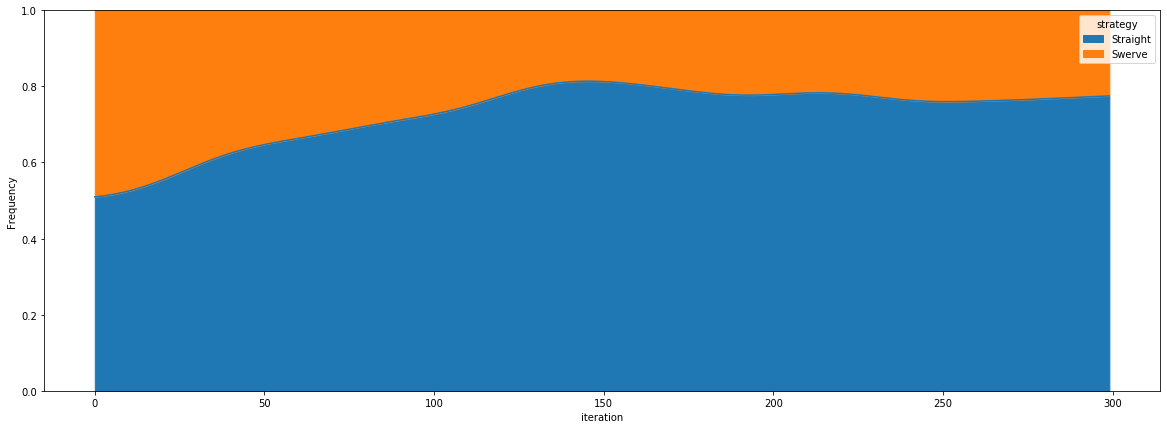

In [54]:
def plot_frequencies():
    counts = df.groupby(['iteration', 'strategy'])['agent'].count().reset_index().pivot(index='iteration', columns='strategy', values='agent')
    (counts / POPULATION_SIZE).rolling(100, 1, True, 'gaussian').mean(std=13).plot.area(figsize=(20, 7))
    plt.ylim(0, 1)
    plt.ylabel('Frequency');
    
plot_frequencies()

The same analysis, without smoothing, and compared to the expected evolutionary stable equilibrium.

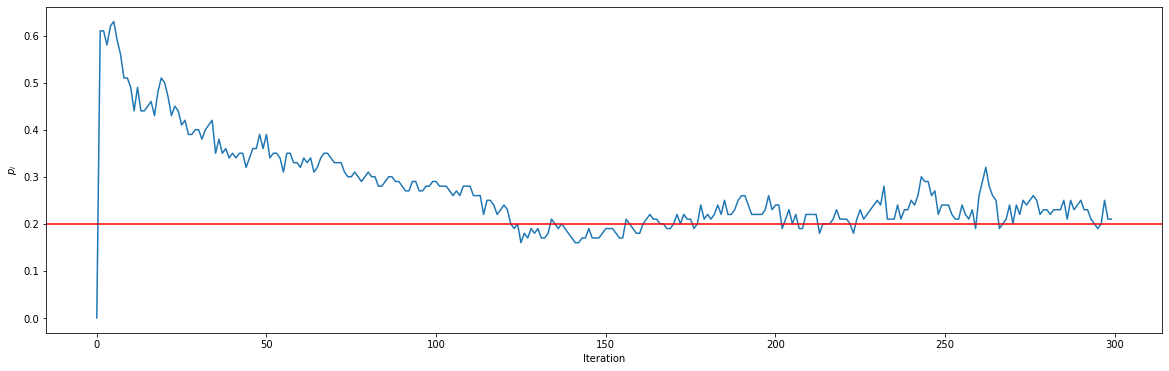

In [55]:
df.groupby('iteration')['strategy_index'].mean().plot(figsize=(20, 6))
plt.axhline(0.2, color='red')
plt.xlabel('Iteration')
plt.ylabel(r'$p_i$');

The average payoff of agents over iterations, separated by the chosen strategy.  
It converge to the same value, as we expect.

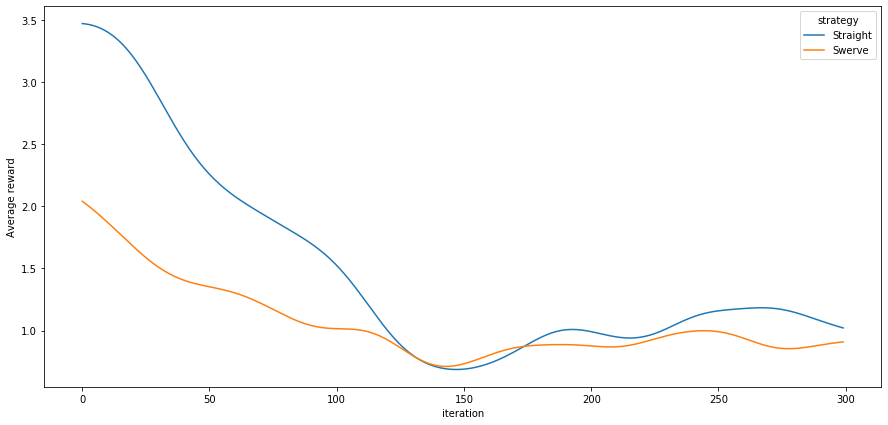

In [56]:
def plot_average_rewards():
    rewards = df.groupby(['iteration', 'strategy'])['actual_reward'].mean().reset_index().pivot(index='iteration', columns='strategy', values='actual_reward')
    rewards.rolling(100, 1, True, 'gaussian').mean(std=13).plot(figsize=(15, 7))
    plt.ylabel('Average reward');
    
plot_average_rewards()

## Experiment \#2
**Game:** Rock paper scissors (2 players)  
**Input:** opponents previous strategies  
**Loss:** probabilistic

In [57]:
POPULATION_SIZE = 100
MEMORY = 5
MEMORY_TYPE = 'opponents_previous_strategies'
LOSS_FUNCTION = 'probabilistic'
ITERATIONS = 300
GAME = 'Rock paper scissors'

In [58]:
game_strategies = np.array(GAME_DEFINITIONS[GAME]['strategies'])
game_rewards = np.array(GAME_DEFINITIONS[GAME]['rewards'])
game_num_of_players = game_rewards.ndim - 1
game_num_of_strategies = len(game_strategies)

if POPULATION_SIZE % game_num_of_players > 0:
    raise Exception('POPULATION_SIZE must be a multiple of the number of players')

In [59]:
loss = get_loss_function()
histories, first_history_record = get_histories()
agents = init_agents()
df = execute_experiment()

In [60]:
df.head()

,iteration,agent,rewards,loss,strategy_index,prediction,strategy,actual_reward
40,0,0,"[0.0, 1.0, -1.0]",1.098612,0,0.0,Rock,0.0
34,0,1,"[0.0, 1.0, -1.0]",1.098612,0,0.0,Rock,0.0
39,0,2,"[0.0, 1.0, -1.0]",1.098612,0,0.0,Rock,0.0
70,0,3,"[0.0, 1.0, -1.0]",1.098612,0,0.0,Rock,0.0
65,0,4,"[0.0, 1.0, -1.0]",1.098612,0,0.0,Rock,0.0


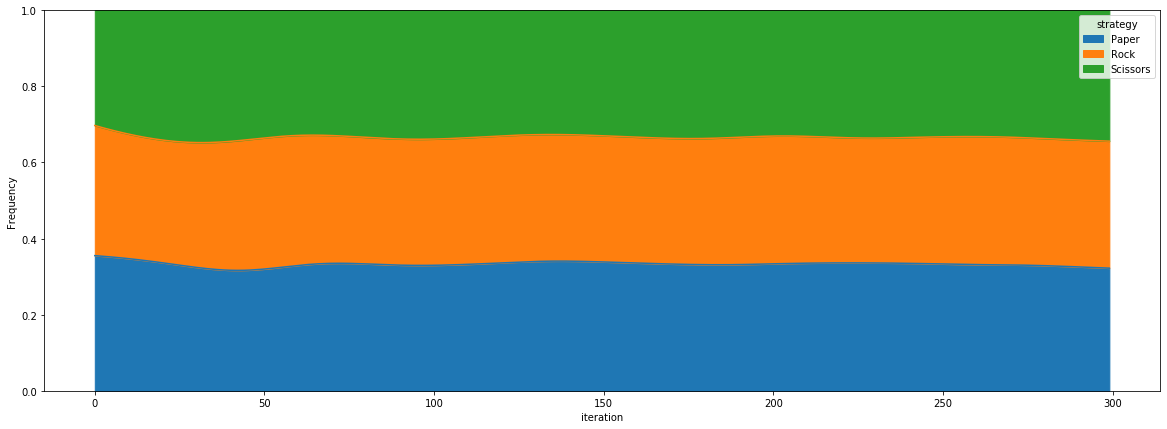

In [61]:
plot_frequencies()

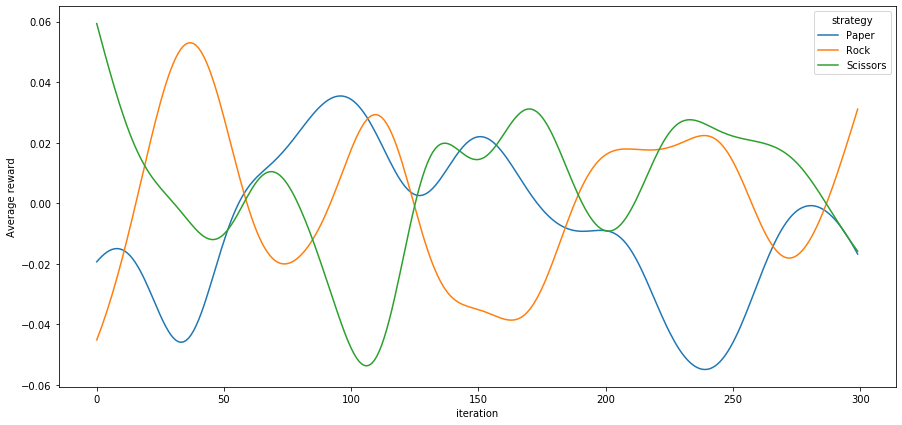

In [62]:
plot_average_rewards()

## Experiment \#3
**Game:** Pollution game (3 players)  
**Input:** opponents previous strategies  
**Loss:** payoff prediction

In [65]:
POPULATION_SIZE = 120
MEMORY = 7
MEMORY_TYPE = 'opponents_previous_strategies'
LOSS_FUNCTION = 'payoff_estimation'
ITERATIONS = 300
GAME = 'Pollution game'

In [66]:
game_strategies = np.array(GAME_DEFINITIONS[GAME]['strategies'])
game_rewards = np.array(GAME_DEFINITIONS[GAME]['rewards'])
game_num_of_players = game_rewards.ndim - 1
game_num_of_strategies = len(game_strategies)

if POPULATION_SIZE % game_num_of_players > 0:
    raise Exception('POPULATION_SIZE must be a multiple of the number of players')

In [67]:
loss = get_loss_function()
histories, first_history_record = get_histories()
agents = init_agents()
df = execute_experiment()

In [69]:
df.head()

,iteration,agent,rewards,loss,strategy_index,prediction,strategy,actual_reward
79,0,0,"[3.0, 4.0]",12.5,0,0.0,Pollute,3.0
106,0,1,"[3.0, 4.0]",12.5,0,0.0,Pollute,3.0
88,0,2,"[3.0, 4.0]",12.5,0,0.0,Pollute,3.0
84,0,3,"[4.0, 4.0]",16.0,0,0.0,Pollute,4.0
48,0,4,"[4.0, 4.0]",16.0,0,0.0,Pollute,4.0


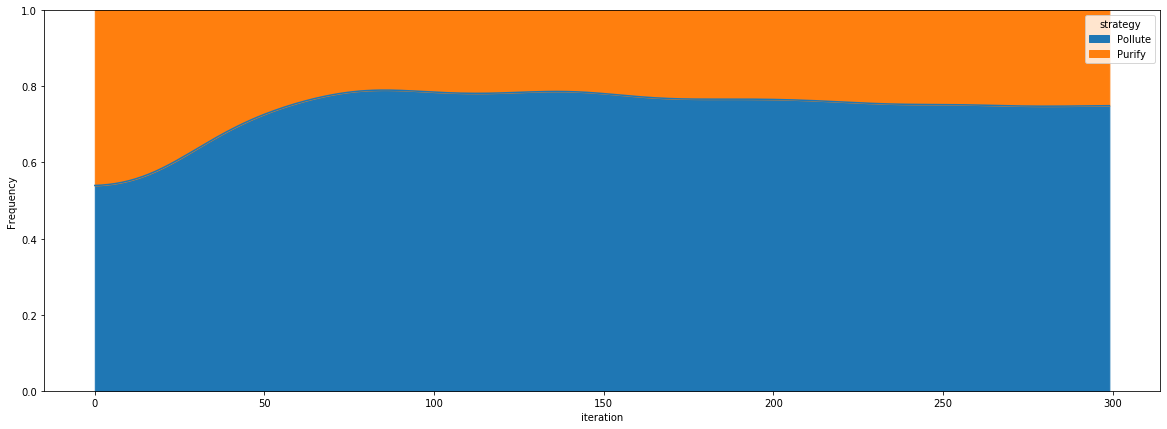

In [70]:
plot_frequencies()

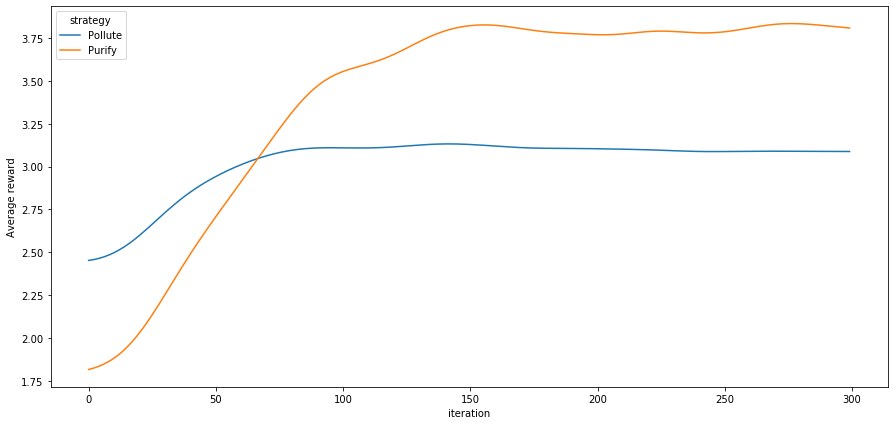

In [71]:
plot_average_rewards()